# Supplements

Notebook to make regional, national, and city-level exposure trends tables and supplement figures. <br>

By Cascade Tuholske Sep 2020 

In [1]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from matplotlib import rcParams

## Tables

In [2]:
#### Load Data
# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/AllDATA-GHS-ERA5-HI406-PDAYS.csv'
HI_STATS = pd.read_csv(DATA_IN+FN_IN)

In [3]:
# Drop IDs where days 1983 = 1 with none else. throws error in regressions 

print(len(HI_STATS))
only83 = HI_STATS.groupby('ID_HDC_G0')['total_days'].sum() == 1 # sum up total days and find those with 1 day
only83 = list(only83[only83 == True].index) # make a list of IDs
sub = HI_STATS[HI_STATS['ID_HDC_G0'].isin(only83)] # subset those IDs
bad_ids = sub[(sub['year'] == 1983) & (sub['total_days'] == 1)] # drop those from 1983 only
drop_list = list(bad_ids['ID_HDC_G0']) # make a list
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)] # drop those from the list
print(len(HI_STATS))

390524
390354


In [4]:
#### Add In Meta Data
geog = ['region', 'intermediate-region', 'sub-region','CTR_MN_NM', 'ID_HDC_G0', 'GCPNT_LAT', 'GCPNT_LON']
meta_fn = 'processed/AllDATA-GHS-ERA5-HI406-META.csv'
all_data = pd.read_csv(DATA_IN+meta_fn)
meta = all_data[geog]
meta = meta.drop_duplicates('ID_HDC_G0')

# Merge it
HI_STATS = HI_STATS.merge(meta, on = 'ID_HDC_G0', how = 'inner')

In [5]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 
def lm_func(df, col):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1])
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

In [6]:
geog = 'sub-region'
loc_list = np.unique(HI_STATS[geog])

In [31]:
#### regional-level exposure trajectories 
fn_out = 'processed/AllDATA-GHS-ERA5-HI406-PDAYS-REGION.csv'
geog = 'sub-region'
loc_list = np.unique(HI_STATS[geog])

pday_coef = []
pday_p =[]
heat_coef = []
heat_p =[]
pop_coef = []
pop_p =[]
for loc in loc_list:
    
    # Pdays OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days')
    pday_coef.append(coef)
    pday_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_heat')
    heat_coef.append(coef)
    heat_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_pop')
    pop_coef.append(coef)
    pop_p.append(p)
    
df = pd.DataFrame()
df['region'] = loc_list
df['pdays_Coef'] = pday_coef
df['pdays_pvalue'] = pday_p
df['heat_Coef'] = heat_coef
df['heat_pvalue'] = heat_p
df['pop_Coef'] = pop_coef
df['pop_pvalue'] = pop_p
df.to_csv(DATA_IN+fn_out)

In [37]:
#### National-level exposure trajectories 
fn_out = 'processed/AllDATA-GHS-ERA5-HI406-PDAYS-COUNTRY.csv'
geog = 'CTR_MN_NM'
loc_list = np.unique(HI_STATS[geog])

pday_coef = []
pday_p =[]
heat_coef = []
heat_p =[]
pop_coef = []
pop_p =[]
for loc in loc_list:
    
    # Pdays OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days')
    pday_coef.append(coef)
    pday_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_heat')
    heat_coef.append(coef)
    heat_p.append(p)
    
    # People OLS
    loc_stats = HI_STATS[HI_STATS[geog] == loc]
    coef, r2, p = lm_func(loc_stats, 'people_days_pop')
    pop_coef.append(coef)
    pop_p.append(p)
    
df = pd.DataFrame()
df[geog] = loc_list
df['pdays_Coef'] = pday_coef
df['pdays_pvalue'] = pday_p
df['heat_Coef'] = heat_coef
df['heat_pvalue'] = heat_p
df['pop_Coef'] = pop_coef
df['pop_pvalue'] = pop_p
df.to_csv(DATA_IN+fn_out)

In [33]:
#### Check USA
# Pdays OLS
col = 'people_days_heat'
df= HI_STATS[HI_STATS['CTR_MN_NM'] == 'United States']
X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

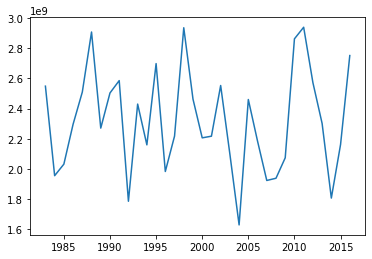

In [34]:
import matplotlib.pyplot as plt
plt.plot(X_year, Y_stats)

In [36]:
# Add Intercept
X_year_2 = sm.add_constant(X_year)

# Regress
model = sm.OLS(Y_stats, X_year_2).fit() 

coef = int(model.params[1])
#coef = int(coef)

# R2 and P
r2 = model.rsquared_adj
p = model.pvalues[0]

print("USA:", coef, round(r2, 2), round(p, 3))

USA: -779309 -0.03 0.755


In [9]:
#### Top fifty cities
cities = pd.read_csv(DATA_IN+'/processed/AllDATA-GHS-ERA5-HI406-MAPDATA_PDAYS_P05.csv')
ghs = gpd.read_file('/home/cascade/tana-crunch-cascade/projects/UrbanHeat/data/raw/GHS_UCDB/GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_0.shp')

In [10]:
nms = ghs[['ID_HDC_G0', 'UC_NM_MN']]
top50 = cities.sort_values('coef_pdays', ascending = False).head(50)
top50 = top50.merge(nms, on = 'ID_HDC_G0', how = 'inner')
top50.to_csv(DATA_IN+'processed/AllDATA-GHS-ERA5-HI406-PDAYS-TOP50.csv')

## Figures

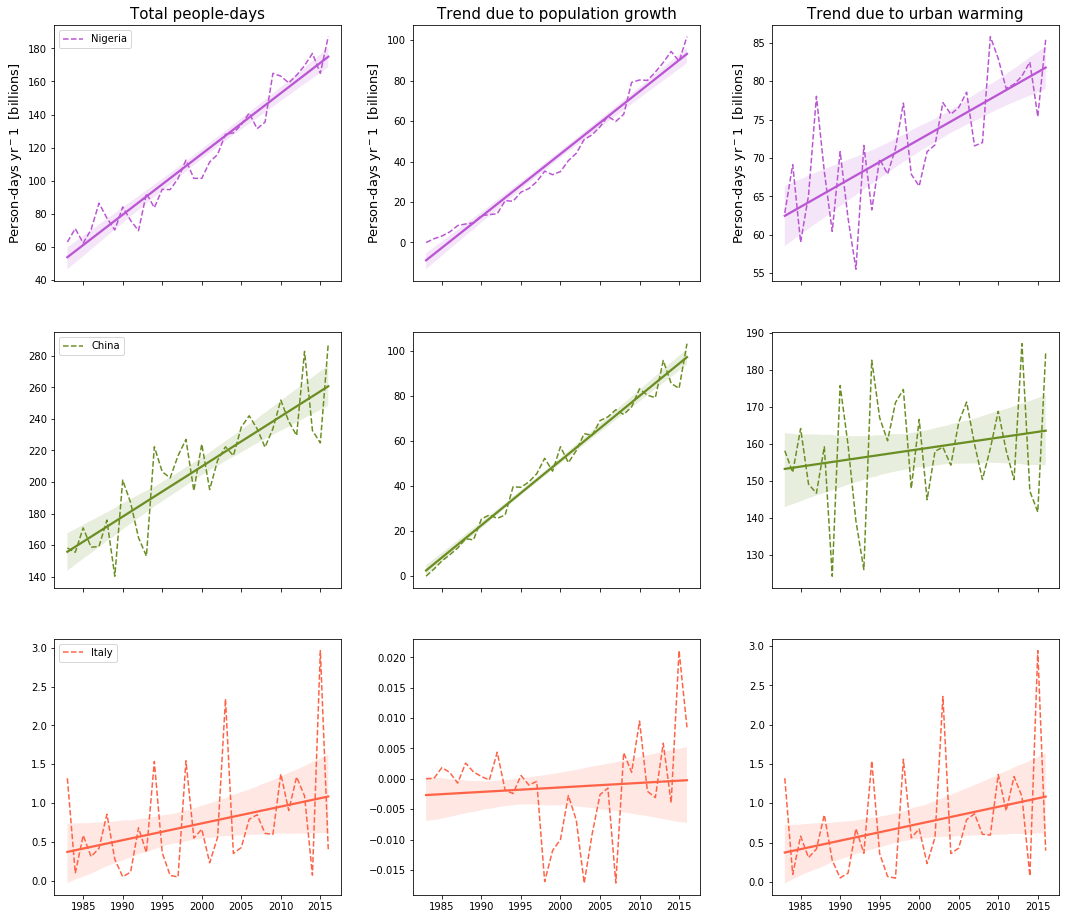

In [11]:
#### Make Supplement 2 
FN_OUT = 'FIGS2-ERA5-Final.png'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(3, 3, figsize = (18, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**8

#### Nigeria
country = 'Nigeria'
color = 'mediumorchid'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[0][0].legend(labels = [country])
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][0], scatter = False, truncate = True)
axs[0][0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)
axs[0][0].set_title('Total people-days', size = 15 )

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][1], scatter = False, truncate = True)
axs[0][1].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][2], scatter = False, truncate = True)
axs[0][2].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

#### China
country = 'China'
color = 'olivedrab'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[1][0].legend(labels = [country])
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][0], scatter = False, truncate = True)
axs[0][1].set_title('Trend due to population growth', size = 15)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][2], scatter = False, truncate = True)

#### Italy
country = 'Italy'
color = 'tomato'
col = 'people_days'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[2][0].legend(labels = [country])
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][0], scatter = False, truncate = True)
axs[0][2].set_title('Trend due to urban warming', size = 15)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['CTR_MN_NM'] == country]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][2], scatter = False, truncate = True)

# save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')

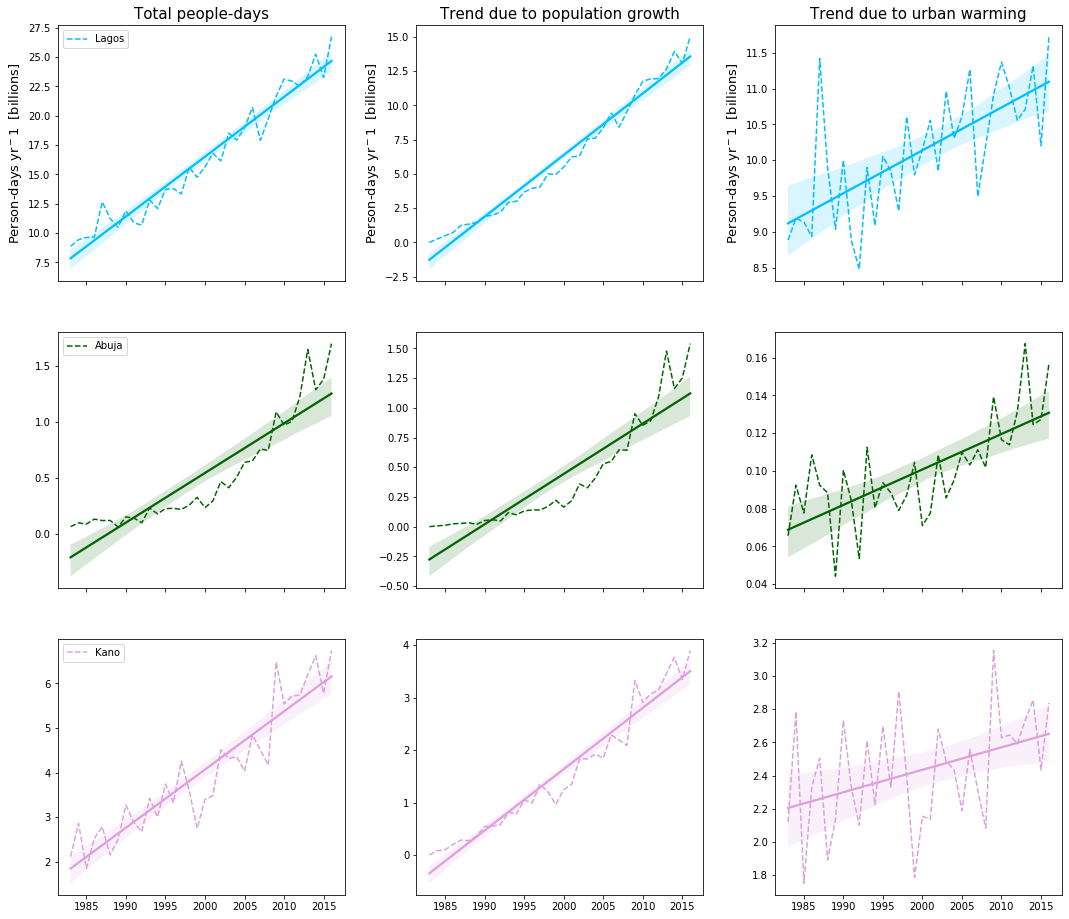

In [12]:
#### Make Figure S3 and save it
FN_OUT = 'FIGS3-ERA5-Final.png'

rcParams['mathtext.default'] = 'regular' # set text to reg, not italic 

fig, axs = plt.subplots(3, 3, figsize = (18, 16), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)
scale = 10**8

#### Lagos
city = 2125 
color = 'deepskyblue'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[0][0].legend(labels = ['Lagos'])
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][0], scatter = False, truncate = True)
axs[0][0].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)
axs[0][0].set_title('Total people-days', size = 15 )

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][1], scatter = False, truncate = True)
axs[0][1].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum() / scale)
axs[0][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[0][2], scatter = False, truncate = True)
axs[0][2].set_ylabel('Person-days $yr^-1$  [billions] ', fontsize = 13)

#### Abuja
city = 2565 #10687
color = 'darkgreen'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[1][0].legend(labels = ['Abuja'])
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][0], scatter = False, truncate = True)
axs[0][1].set_title('Trend due to population growth', size = 15)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[1][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[1][2], scatter = False, truncate = True)

#### Kano
city = 2717
color = 'plum'
col = 'people_days'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][0].plot(X_year, Y_stats, color = color, linestyle = '--')
axs[2][0].legend(labels = ['Kano'])
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][0], scatter = False, truncate = True)
axs[0][2].set_title('Trend due to urban warming', size = 15)

col = 'people_days_pop'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][1].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][1], scatter = False, truncate = True)

col = 'people_days_heat'
df = HI_STATS[HI_STATS['ID_HDC_G0'] == city]
X_year = list(df.groupby('year')['ID_HDC_G0'].mean().index)
Y_stats = list(df.groupby('year')[col].sum()/ scale)
axs[2][2].plot(X_year, Y_stats, color = color, linestyle = '--')
sns.regplot(X_year, Y_stats, color = color, ax = axs[2][2], scatter = False, truncate = True)

# save it out
plt.savefig(FIG_OUT+FN_OUT, dpi = 300, bbox_inches='tight')